Dimensões originais: (1552210, 44)
Epoch 1/20, Loss: 0.1334
Epoch 2/20, Loss: 0.1282
Epoch 3/20, Loss: 0.1273
Epoch 4/20, Loss: 0.1267
Epoch 5/20, Loss: 0.1261
Epoch 6/20, Loss: 0.1257
Epoch 7/20, Loss: 0.1251
Epoch 8/20, Loss: 0.1247
Epoch 9/20, Loss: 0.1245
Epoch 10/20, Loss: 0.1241
Epoch 11/20, Loss: 0.1237
Epoch 12/20, Loss: 0.1236
Epoch 13/20, Loss: 0.1234
Epoch 14/20, Loss: 0.1231
Epoch 15/20, Loss: 0.1229
Epoch 16/20, Loss: 0.1227
Epoch 17/20, Loss: 0.1224
Epoch 18/20, Loss: 0.1224
Epoch 19/20, Loss: 0.1221
Epoch 20/20, Loss: 0.1220
LSTM (PyTorch):
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    449376
           1       0.65      0.02      0.04     16287

    accuracy                           0.97    465663
   macro avg       0.81      0.51      0.51    465663
weighted avg       0.95      0.97      0.95    465663

Random Forest:
               precision    recall  f1-score   support

           0       0.97      1.00      

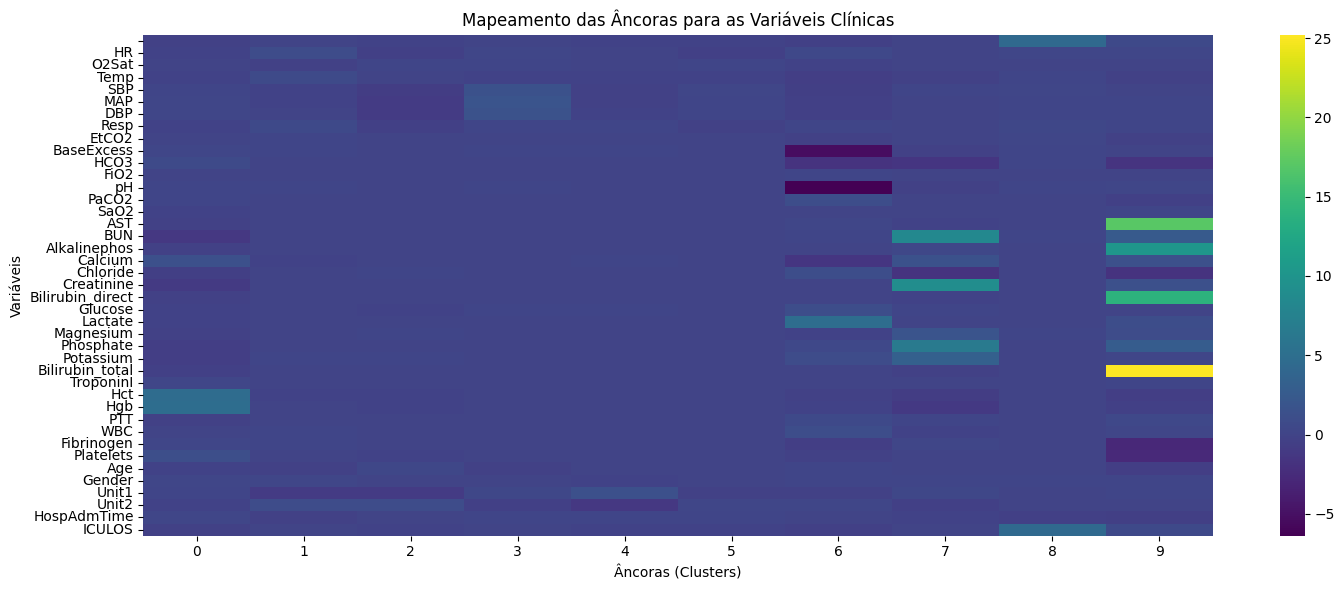

Acurácia do MSC puro (1 perfil por classe): 0.7920
Acurácia do MSC com múltiplos perfis por classe: 0.6399


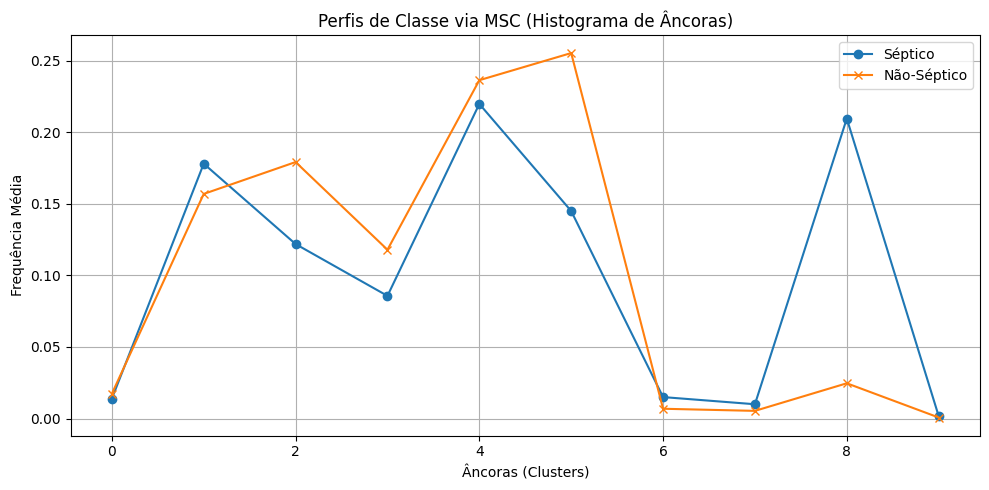

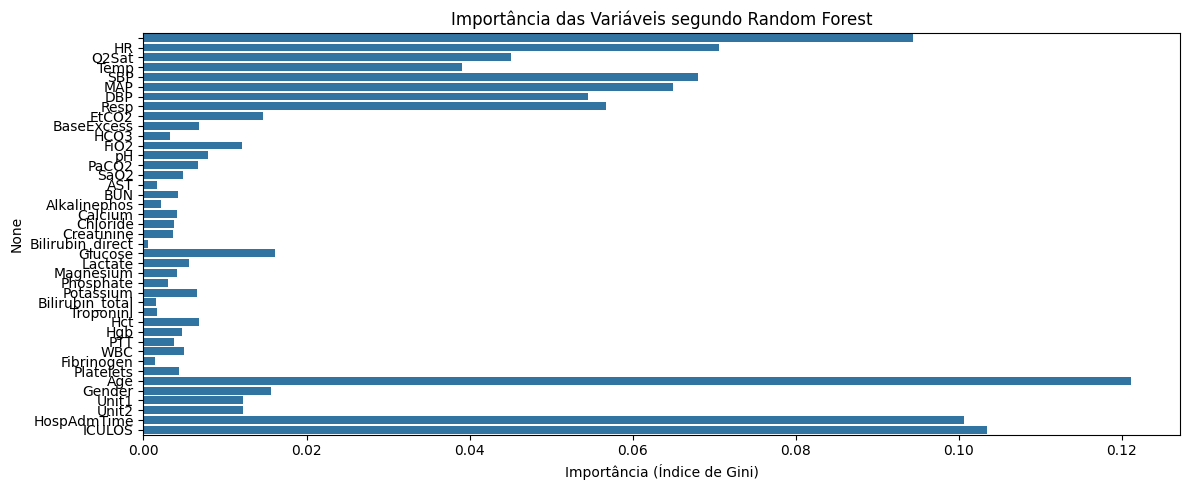

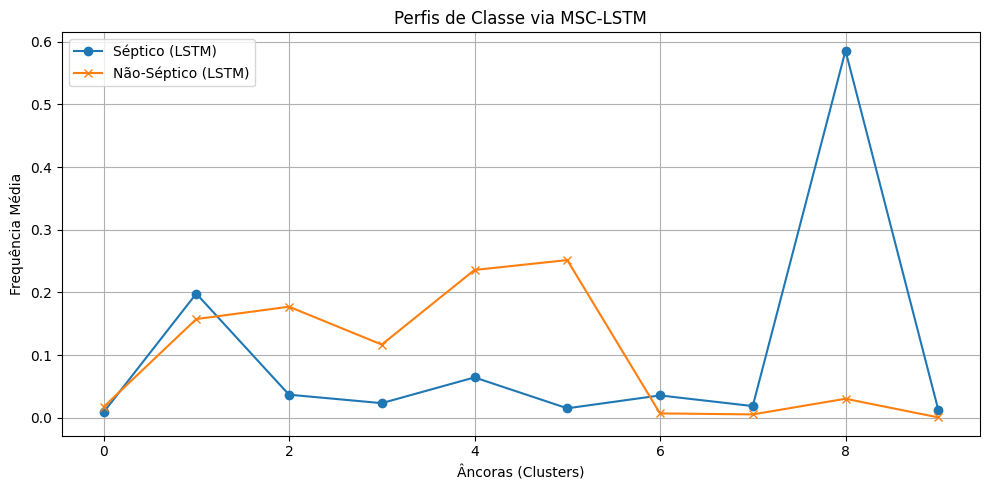

Fidelidade MSC-LSTM ao LSTM: 0.7988
Utilidade média (aproximada): 0.4897


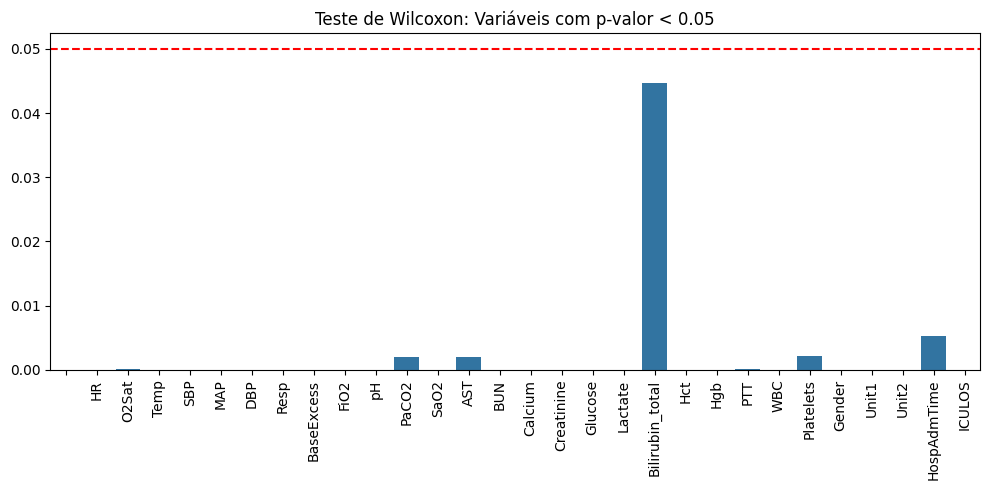


=== Tabela de Sobreposição com Variáveis Clínicas e da Literatura ===
             Importância RF  Clínica  Literatura  Ambas
Age                0.121060    False        True   True
ICULOS             0.103496    False       False  False
HospAdmTime        0.100652    False       False  False
                   0.094350    False       False  False
HR                 0.070611    False       False  False
SBP                0.067995    False       False  False
MAP                0.064933    False       False  False
Resp               0.056778    False       False  False
DBP                0.054568    False       False  False
O2Sat              0.045131    False       False  False
Temp               0.039121     True       False   True
Glucose            0.016163    False        True   True
Gender             0.015690    False       False  False
EtCO2              0.014608    False       False  False
Unit2              0.012256    False       False  False
Unit1              0.012197    Fa

<Figure size 1000x500 with 0 Axes>

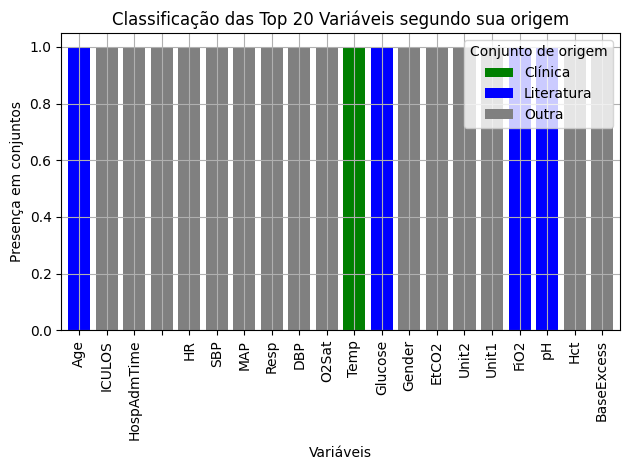

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from scipy.stats import wilcoxon
import warnings
warnings.filterwarnings("ignore")

# Importações para a PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Leitura e Pré-processamento
with open("Dataset.csv", "r") as f:
    lines = f.readlines()

if lines[-1].strip() == "":
    lines = lines[:-1]

header = lines[0].strip().split(",")
data = [line.strip().split(",") for line in lines[1:]]
data = [row for row in data if len(row) == len(header)]  # garantindo integridade de leitura

df = pd.DataFrame(data, columns=header)
df = df.apply(pd.to_numeric, errors='coerce')

print("Dimensões originais:", df.shape)

# Mudança de Rótulo (1, 6, 12 horas antes)
def apply_label_shift(df, label_column="SepsisLabel", time_column="Hour", shift_hours=[1, 6, 12]):
    df_shifted = df.copy()
    if "Patient_ID" not in df.columns:
        df_shifted["Patient_ID"] = 0
    patient_ids = df_shifted["Patient_ID"].unique()

    for pid in patient_ids:
        patient_data = df_shifted[df_shifted["Patient_ID"] == pid]
        sepsis_indices = patient_data[patient_data[label_column] == 1].index
        for i in sepsis_indices:
            for h in shift_hours:
                target_idx = i - h
                if target_idx in df_shifted.index and df_shifted.at[target_idx, "Patient_ID"] == pid:
                    df_shifted.at[target_idx, label_column] = 1
    return df_shifted

df = apply_label_shift(df)

# Preparação para LSTM e RF *

# Separando features e rótulos
drop_cols = ["SepsisLabel", "Patient_ID", "Hour"]
features = df.drop(columns=drop_cols, errors='ignore')
labels = df["SepsisLabel"].fillna(0)

# Preenchimento e padronização
features = features.fillna(features.mean())
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Redimensionamento para LSTM (3D) e codificação dos rótulos
X = features_scaled.reshape((features_scaled.shape[0], 1, features_scaled.shape[1]))
# Utilizando labels inteiros para usar CrossEntropyLoss
y = np.argmax(pd.get_dummies(labels), axis=1)

# Divisão de treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinamento do LSTM com PyTorch *

# Definição do modelo LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64, fc1_size=32, output_size=2, dropout_rate=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, output_size)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch, seq_len, hidden_size)
        x = lstm_out[:, -1, :]      # usa a última saída da sequência
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_size = X_train.shape[2]
model = LSTMClassifier(input_size=input_size)

# Hiperparâmetros e configuração do treinamento
num_epochs = 20
batch_size = 128
learning_rate = 0.001

# Valores mais adequados:
# hidden_size = 128
# fc1_size = 64
# output_size = 2
# dropout_rate = 0.4
# num_epochs = 150
# batch_size = 64
# learning_rate = atual

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Conversão dos dados para tensores do PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Criação do DataLoader para o conjunto de treino
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Loop de treinamento
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Avaliação no conjunto de teste
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
predicted = predicted.numpy()
print("LSTM (PyTorch):\n", classification_report(y_test, predicted))

# Treinamento do Random Forest (CSE) *

# Remodelagem dos dados para o RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)
y_pred_rf = rf.predict(X_test.reshape(X_test.shape[0], X_test.shape[2]))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

# Mecanismo de Interpretação (MSC) *

# Redução de dimensionalidade com PCA
X_flat = X.reshape(X.shape[0], X.shape[2])
X_reduced = PCA(n_components=10).fit_transform(X_flat)

# Clustering (âncoras)
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

# Mapeamento das âncoras para as variáveis originais *

# Agrupar os dados originais (X_flat) por cluster atribuído pelo KMeans
X_by_cluster = {i: [] for i in range(kmeans.n_clusters)}
for idx, cluster_id in enumerate(clusters):
    X_by_cluster[cluster_id].append(X_flat[idx])

# Calcular a média por variável em cada âncora
anchor_profiles = {}
for cluster_id, instances in X_by_cluster.items():
    instances_array = np.array(instances)
    if instances_array.shape[0] > 0:
        anchor_profiles[cluster_id] = instances_array.mean(axis=0)
    else:
        anchor_profiles[cluster_id] = np.zeros(X_flat.shape[1])  # fallback

# Criar DataFrame para visualização
anchor_df = pd.DataFrame.from_dict(anchor_profiles, orient="index", columns=features.columns)

# Plotar o heatmap das âncoras
plt.figure(figsize=(15, 6))
sns.heatmap(anchor_df.T, cmap="viridis", annot=False, xticklabels=True, yticklabels=True)
plt.title("Mapeamento das Âncoras para as Variáveis Clínicas")
plt.xlabel("Âncoras (Clusters)")
plt.ylabel("Variáveis")
plt.tight_layout()
plt.show()

# Impressões digitais (fingerprints)
fingerprints = np.zeros((X.shape[0], 10))
for i, c in enumerate(clusters):
    fingerprints[i][c] += 1

# Perfis de classe - versão com 1 perfil (média global)
septic = fingerprints[y == 1]
non_septic = fingerprints[y == 0]
avg_septic = septic.mean(axis=0)
avg_non_septic = non_septic.mean(axis=0)

# Avaliação do MSC puro
y_pred_msc = [1 if (fingerprints[i] @ avg_septic > fingerprints[i] @ avg_non_septic) else 0 for i in range(len(fingerprints))]
acc_msc = accuracy_score(y, y_pred_msc)
print(f"Acurácia do MSC puro (1 perfil por classe): {acc_msc:.4f}")

# Perfis de classe com múltiplos subgrupos (via KMeans) *
n_profiles = 3  # incrementado por recomendação do artigo

septic = fingerprints[y == 1]
non_septic = fingerprints[y == 0]

kmeans_septic = KMeans(n_clusters=n_profiles, random_state=42).fit(septic)
kmeans_non_septic = KMeans(n_clusters=n_profiles, random_state=42).fit(non_septic)

profiles_septic = kmeans_septic.cluster_centers_
profiles_non_septic = kmeans_non_septic.cluster_centers_

# Predição baseada em múltiplos perfis por classe
y_pred_msc_multi = []
for i in range(len(fingerprints)):
    sample_fp = fingerprints[i]
    sim_septic = max([np.dot(sample_fp, p) for p in profiles_septic])
    sim_non_septic = max([np.dot(sample_fp, p) for p in profiles_non_septic])
    y_pred_msc_multi.append(1 if sim_septic > sim_non_septic else 0)

# Avaliação do MSC com múltiplos perfis
acc_msc_multi = accuracy_score(y, y_pred_msc_multi)
print(f"Acurácia do MSC com múltiplos perfis por classe: {acc_msc_multi:.4f}")

# Visualização
plt.figure(figsize=(10, 5))
plt.plot(avg_septic, label="Séptico", marker='o')
plt.plot(avg_non_septic, label="Não-Séptico", marker='x')
plt.title("Perfis de Classe via MSC (Histograma de Âncoras)")
plt.xlabel("Âncoras (Clusters)")
plt.ylabel("Frequência Média")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Importância das Features no RF
importances = rf.feature_importances_
feature_names = features.columns

# Visualização
plt.figure(figsize=(12, 5))
sns.barplot(x=importances, y=feature_names, orient='h')
plt.title("Importância das Variáveis segundo Random Forest")
plt.xlabel("Importância (Índice de Gini)")
plt.tight_layout()
plt.show()

# Criando rótulos preditos pelo LSTM para gerar o modelo híbrido MSC-LSTM
model.eval()
with torch.no_grad():
    outputs_lstm = model(torch.tensor(X, dtype=torch.float32))
    _, y_pred_lstm = torch.max(outputs_lstm, 1)

# Construindo MSC com base no LSTM (modelo híbrido MSC-LSTM)
X_flat = X.reshape(X.shape[0], X.shape[2])
X_reduced = PCA(n_components=10).fit_transform(X_flat)

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

# Fingerprints com rótulos do LSTM (híbrido)
fingerprints_lstm = np.zeros((X.shape[0], 10))
for i, c in enumerate(clusters):
    fingerprints_lstm[i][c] += 1

# Perfis de classe com base no rótulo predito do LSTM
septic_lstm = fingerprints_lstm[y_pred_lstm == 1]
non_septic_lstm = fingerprints_lstm[y_pred_lstm == 0]
avg_septic_lstm = septic_lstm.mean(axis=0)
avg_non_septic_lstm = non_septic_lstm.mean(axis=0)

# Visualização dos perfis de classe híbridos
plt.figure(figsize=(10, 5))
plt.plot(avg_septic_lstm, label="Séptico (LSTM)", marker='o')
plt.plot(avg_non_septic_lstm, label="Não-Séptico (LSTM)", marker='x')
plt.title("Perfis de Classe via MSC-LSTM")
plt.xlabel("Âncoras (Clusters)")
plt.ylabel("Frequência Média")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Fidelidade: Comparação MSC-LSTM vs LSTM
y_pred_msc_lstm = [1 if (fingerprints_lstm[i] @ avg_septic_lstm > fingerprints_lstm[i] @ avg_non_septic_lstm) else 0 for i in range(len(fingerprints_lstm))]

fidelidade = accuracy_score(y_pred_lstm.numpy(), y_pred_msc_lstm)
print(f"Fidelidade MSC-LSTM ao LSTM: {fidelidade:.4f}")

# Validação cruzada + Métrica de utilidade (simplificada, não oficial)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
utilidade_simples = []
for train_idx, test_idx in skf.split(X_flat, y):
    rf_cv = RandomForestClassifier(n_estimators=100)
    rf_cv.fit(X_flat[train_idx], y[train_idx])
    y_pred = rf_cv.predict(X_flat[test_idx])
    acuracia = accuracy_score(y[test_idx], y_pred)
    precocidade = np.mean((y_pred == 1) & (y[test_idx] == 1))  # métrica proxy da utilidade
    utilidade_simples.append((acuracia + precocidade) / 2)
print(f"Utilidade média (aproximada): {np.mean(utilidade_simples):.4f}")

# Teste de Wilcoxon para características
feature_df = pd.DataFrame(X_flat, columns=features.columns)
labels_binary = (y == 1).astype(int)

wilcoxon_results = {}
for col in feature_df.columns:
    group1 = feature_df[col][labels_binary == 1]
    group0 = feature_df[col][labels_binary == 0]
    try:
        stat, p_value = wilcoxon(group1.sample(min(len(group1), len(group0))), group0.sample(min(len(group1), len(group0))) )
        wilcoxon_results[col] = p_value
    except:
        continue

# Visualização dos p-valores
sig_results = {k: v for k, v in wilcoxon_results.items() if v < 0.05}
plt.figure(figsize=(10, 5))
sns.barplot(x=list(sig_results.keys()), y=list(sig_results.values()))
plt.axhline(0.05, color='red', linestyle='--')
plt.title("Teste de Wilcoxon: Variáveis com p-valor < 0.05")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Análise expandida: Sobreposição com variáveis clínicas e da literatura *

# Conjuntos baseados na literatura e conhecimento médico
variaveis_clinicas = {'HeartRate', 'RespRate', 'MeanBP', 'Temp', 'WBC', 'Platelets'}
variaveis_literatura = {'pH', 'Chloride', 'Glucose', 'Age', 'BUN', 'Creatinine', 'Lactate', 'FiO2', 'SpO2'}

# Selecionar as top-N variáveis mais importantes do Random Forest
N = 20
importances_rf = rf.feature_importances_
indices_ordenados = np.argsort(importances_rf)[::-1]
top_features = [features.columns[i] for i in indices_ordenados[:N]]

# Cálculo da sobreposição
intersec_clinicas = variaveis_clinicas.intersection(top_features)
intersec_literatura = variaveis_literatura.intersection(top_features)
intersec_ambas = intersec_clinicas.union(intersec_literatura)

# Tabela de presença/ausência para as top-N variáveis
tabela_sobreposicao = pd.DataFrame(index=top_features)
tabela_sobreposicao['Importância RF'] = [importances_rf[features.columns.get_loc(f)] for f in top_features]
tabela_sobreposicao['Clínica'] = tabela_sobreposicao.index.isin(variaveis_clinicas)
tabela_sobreposicao['Literatura'] = tabela_sobreposicao.index.isin(variaveis_literatura)
tabela_sobreposicao['Ambas'] = tabela_sobreposicao['Clínica'] | tabela_sobreposicao['Literatura']

# Exibir tabela
print("\n=== Tabela de Sobreposição com Variáveis Clínicas e da Literatura ===")
print(tabela_sobreposicao)

# Visualização: barras empilhadas
cores = tabela_sobreposicao[['Clínica', 'Literatura']].astype(int)
cores['Outra'] = 1 - cores.max(axis=1)

plt.figure(figsize=(10, 5))
cores[['Clínica', 'Literatura', 'Outra']].plot(kind='bar', stacked=True, color=['green', 'blue', 'gray'], width=0.8)
plt.xticks(ticks=range(len(top_features)), labels=top_features, rotation=90)
plt.title("Classificação das Top 20 Variáveis segundo sua origem")
plt.xlabel("Variáveis")
plt.ylabel("Presença em conjuntos")
plt.legend(title="Conjunto de origem")
plt.tight_layout()
plt.grid(True)
plt.show()
